In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


Set up the filters.  "numstds" is the number of standard deviations to take from the median.

Plot some diagnostics

In [3]:
def get_XAS(scan_name, DIR, DIR_json, numstds, minIzero, lin_filter, plotting_inital='no', plot_scans='yes'):
    #numstds = 2
    #minIzero = 0.015

    json_file = DIR_json + scan_name + "_scan_info.json"
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])

#     print ("Processing",numFiles,"files")

    DataFluo_pump_norm_total = np.empty(0)
    DataFluo_unpump_norm_total = np.empty(0)
    err_DataFluo_pump_total = np.empty(0)
    err_DataFluo_unpump_total = np.empty(0)

    IzeroFEL_pump_original_total = np.empty(0)
    IzeroFEL_pump_total = np.empty(0)
    IzeroFEL_unpump_original_total = np.empty(0)
    IzeroFEL_unpump_total = np.empty(0)

    DataFluo_pump_original_total = np.empty(0)
    DataFluo_pump_total = np.empty(0)
    DataFluo_unpump_original_total = np.empty(0)
    DataFluo_unpump_total = np.empty(0)

    Energy_eV = np.empty(0)
    iZero = np.empty(0)

    for i in range(0,numFiles):
    #for i in range(0,1):
        filename = str(data['scan_files'][i][0])
        filename = DIR + os.path.basename(filename)
        exists = os.path.isfile(filename)
        if not exists:
            print("No such file")
        elif exists: #Do we need this 39?
#             print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
            (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, Energy, _, _, _) = \
                load_PumpProbe_events(filename, channel_energy)

            IzeroFEL_pump_original = IzeroFEL_pump.copy()
            IzeroFEL_unpump_original = IzeroFEL_unpump.copy()

            IzeroFEL_pump_original_total = np.append(IzeroFEL_pump_original_total, IzeroFEL_pump_original)
            IzeroFEL_unpump_original_total = np.append(IzeroFEL_unpump_original_total, IzeroFEL_unpump_original)

            DataFluo_pump_original_total = np.append(DataFluo_pump_original_total, DataFluo_pump)
            DataFluo_unpump_original_total = np.append(DataFluo_unpump_original_total, DataFluo_unpump)

            
            
            
            IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump\
                =filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)

            
            
            IzeroFEL_pump_total = np.append(IzeroFEL_pump_total, IzeroFEL_pump)
            IzeroFEL_unpump_total = np.append(IzeroFEL_unpump_total, IzeroFEL_unpump)

            DataFluo_pump_total = np.append(DataFluo_pump_total, DataFluo_pump)
            DataFluo_unpump_total = np.append(DataFluo_unpump_total, DataFluo_unpump)

            DataFluo_pump_norm = DataFluo_pump/IzeroFEL_pump
            DataFluo_unpump_norm = DataFluo_unpump/IzeroFEL_unpump

            DataFluo_pump_norm_total = np.append(DataFluo_pump_norm_total, DataFluo_pump_norm.mean())
            DataFluo_unpump_norm_total = np.append(DataFluo_unpump_norm_total, DataFluo_unpump_norm.mean())
            err_DataFluo_pump_total = np.append(err_DataFluo_pump_total, DataFluo_pump_norm.std()/np.sqrt(DataFluo_pump_norm.size))
            err_DataFluo_unpump_total = np.append(err_DataFluo_unpump_total, DataFluo_unpump_norm.std()/np.sqrt(DataFluo_unpump_norm.size))

            Energy = [x for x in Energy if (np.abs(x) > 0)]
            Energy_eV = np.append(Energy_eV, np.mean(Energy))
            iZero = [x for x in iZero if (np.abs(x) > 0)]
            iZero = np.append(iZero, np.mean(IzeroFEL_pump_total))
            
    Energy_eV = Energy_eV[1:]
    DataFluo_pump_norm_total = DataFluo_pump_norm_total[1:]
    DataFluo_unpump_norm_total = DataFluo_unpump_norm_total[1:]
    iZero =iZero[1:]    
    
    if plotting_inital == 'yes':
    #     print("The original number of pumped and unpumped shots is:")
    #     print(IzeroFEL_pump_original_total.shape, IzeroFEL_unpump_original_total.shape)
    #     print("The filtered number of pumped and unpumped shots is:")
    #     print(IzeroFEL_pump_total.shape, IzeroFEL_unpump_total.shape)
        plt.figure()
        _, bins, _ = plt.hist(IzeroFEL_pump_original_total, 100, label = 'unfiltered')
        _ = plt.hist(IzeroFEL_pump_total, bins, rwidth = .5, label = 'filtered')
        plt.title('Izero, pumped')
        plt.legend()

        plt.figure()
        _, bins, _ = plt.hist(IzeroFEL_unpump_original_total, 100, label = 'unfiltered')
        _ = plt.hist(IzeroFEL_unpump_total, bins, rwidth = .5, label = 'filtered')
        plt.title('Izero, unpumped')
        plt.legend()

      
        plt.figure()
        #hope to see you soon
        plt.scatter(IzeroFEL_pump_original_total, DataFluo_pump_original_total)
        plt.scatter(IzeroFEL_pump_total, DataFluo_pump_total)
        plt.title('Izero, pumped')
        plt.xlabel('I0')
        plt.ylabel('Absorption')

    #     print(Energy_eV.shape)
    #     print(iZero.shape)
    #     print(DataFluo_pump_norm_total.shape)
    #     print(DataFluo_unpump_norm_total.shape)



        plt.figure()
        plt.plot(np.array(Energy_eV), DataFluo_pump_norm_total,label='Pumped')
        plt.plot(np.array(Energy_eV), DataFluo_unpump_norm_total,label='UnPumped')
        plt.plot(np.array(Energy_eV), np.array(iZero)*100,label="I_zero_Arb")
        plt.xlabel('energy (eV)')
        plt.ylabel('absorption')
        plt.title('XAS_'+ scan_name)
        plt.legend()
    
    
    if plot_scans == 'yes':
        a = 4

    return iZero, Energy_eV, DataFluo_unpump_norm_total, DataFluo_pump_norm_total
        

In [4]:
ploton = True

numstds = 3
minIzero = 0.015
lin_filter =0.1

DIR_root = "/sf/alvra/data/p17983/raw/scan_data/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

basename_01 = 'RuBpy3_monoscan_'
scanlist_01 = [12]
strList_01 = list2Str(scanlist_01)


scan_name_01 = scanlist_01
n_01 = len(scanlist_01)



basename_02 = basename_01 #'RuBpy3_monoscan_'
scanlist_02 = [5]
strList_02 = list2Str(scanlist_02)

scan_name_02 = scanlist_02
n_02 = len(scanlist_02)




for i in range(0, n_01):
    if scanlist_01[i] < 10:
        scan_name = basename_01 + '00' + str(scanlist_01[i])
    else:
        scan_name = basename_01 + '0' + str(scanlist_01[i])
        
    DIR = DIR_root + scan_name + "/"

    iZero_, Energy_eV_, DataFluo_unpump_norm_total_, DataFluo_pump_norm_total_\
    =get_XAS(scan_name, DIR, DIR_json, numstds, minIzero,lin_filter,'no','yes')
    print(i)
    if i == 0:
        iZero_01 = iZero_/n_01
        Energy_eV_01 = Energy_eV_/n_01
        DataFluo_unpump_norm_total_01 = DataFluo_unpump_norm_total_/n_01
        DataFluo_pump_norm_total_01 = DataFluo_pump_norm_total_/n_01
    else:
        iZero_01 += iZero_/n_01
        Energy_eV_01 += Energy_eV_/n_01
        DataFluo_unpump_norm_total_01 += DataFluo_unpump_norm_total_/n_01
        DataFluo_pump_norm_total_01 += DataFluo_pump_norm_total_/n_01
    
for i in range(0, n_02):
    if scanlist_02[i] < 10:
        scan_name = basename_02 + '00' + str(scanlist_02[i])
    else:
        scan_name = basename_02 + '0' + str(scanlist_02[i])
        
    DIR = DIR_root + scan_name + "/"

    iZero_, Energy_eV_, DataFluo_unpump_norm_total_, DataFluo_pump_norm_total_\
    =get_XAS(scan_name, DIR, DIR_json, numstds, minIzero,lin_filter,'no','yes')
    print(i)
    if i == 0:
        iZero_02 = iZero_/n_02
        Energy_eV_02 = Energy_eV_/n_02
        DataFluo_unpump_norm_total_02 = DataFluo_unpump_norm_total_/n_02
        DataFluo_pump_norm_total_02 = DataFluo_pump_norm_total_/n_02
    else:
        iZero_02 += iZero_/n_02
        Energy_eV_02 += Energy_eV_/n_02
        DataFluo_unpump_norm_total_02 += DataFluo_unpump_norm_total_/n_02
        DataFluo_pump_norm_total_02 += DataFluo_pump_norm_total_/n_02



/sf/alvra/data/p17983/res/scan_info/RuBpy3_monoscan_012_scan_info.json
0
/sf/alvra/data/p17983/res/scan_info/RuBpy3_monoscan_005_scan_info.json
0


In [5]:
offset_min = 0.1
avg_p_bg_01 = DataFluo_pump_norm_total_01 - min(DataFluo_unpump_norm_total_01) + offset_min
avg_u_bg_01 = DataFluo_unpump_norm_total_01 - min(DataFluo_unpump_norm_total_01) + offset_min

avg_p_bg_02 = DataFluo_pump_norm_total_02 - min(DataFluo_unpump_norm_total_02) + offset_min
avg_u_bg_02 = DataFluo_unpump_norm_total_02 - min(DataFluo_unpump_norm_total_02) + offset_min


diff_01 = (avg_p_bg_01-avg_u_bg_01)/avg_u_bg_01

diff_02 = (avg_p_bg_02-avg_u_bg_02)/avg_u_bg_02

<IPython.core.display.Javascript object>


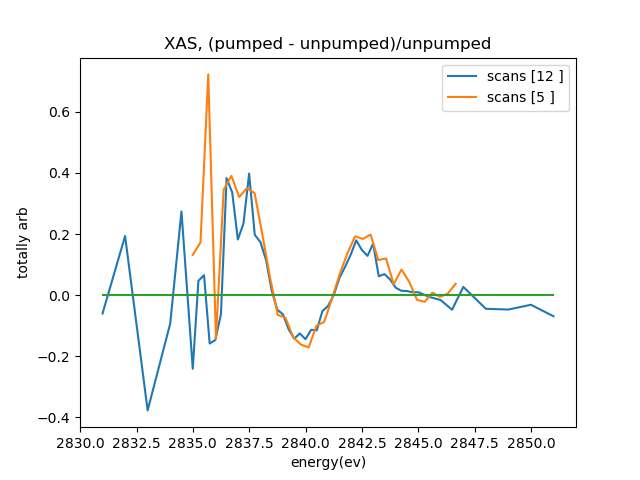

<IPython.core.display.Javascript object>


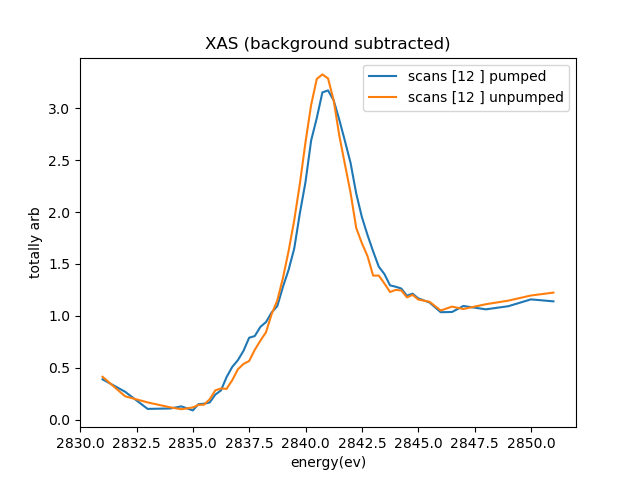

<IPython.core.display.Javascript object>


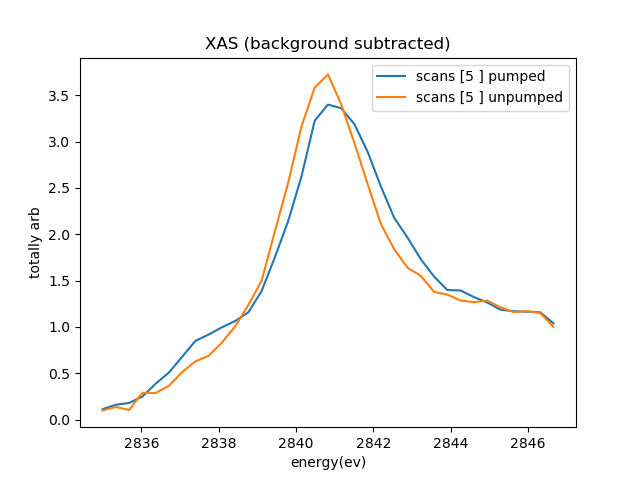

<IPython.core.display.Javascript object>


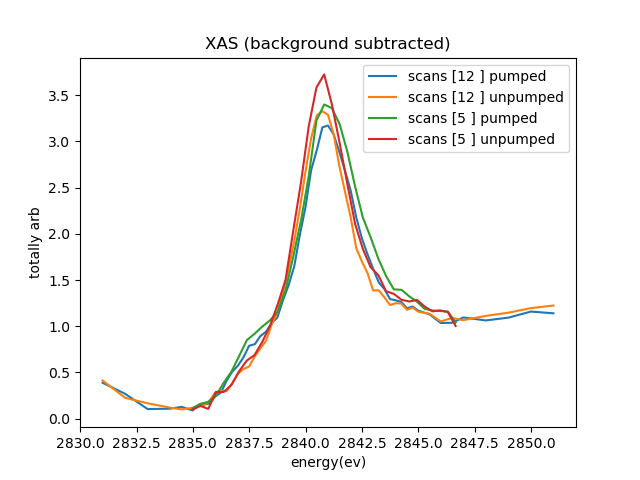

Text(0.5, 0, 'energy(ev)')

In [17]:
plt.figure()
plt.plot(np.array(Energy_eV_01), diff_01, label='scans '+strList_01)
plt.plot(np.array(Energy_eV_02), diff_02, label='scans '+strList_02)
plt.legend()
plt.title('XAS, (pumped - unpumped)/unpumped')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')
if Energy_eV_01.shape[0]>Energy_eV_02.shape[0]:
    zeroLine = np.zeros(np.array(Energy_eV_01).shape)
    plt.plot(np.array(Energy_eV_01),zeroLine)
else:
    zeroLine = np.zeros(np.array(Energy_eV_02).shape)
    plt.plot(np.array(Energy_eV_02),zeroLine)


plt.figure()
plt.plot(np.array(Energy_eV_01), avg_p_bg_01, label='scans '+strList_01+' pumped') 
plt.plot(np.array(Energy_eV_01), avg_u_bg_01, label='scans '+strList_01+' unpumped') 
plt.legend()
plt.title('XAS (background subtracted)')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')


plt.figure()
plt.plot(np.array(Energy_eV_02), avg_p_bg_02, label='scans '+strList_02+' pumped') 
plt.plot(np.array(Energy_eV_02), avg_u_bg_02, label='scans '+strList_02+' unpumped') 
plt.legend()
plt.title('XAS (background subtracted)')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')

plt.figure()
plt.plot(np.array(Energy_eV_01), avg_p_bg_01, label='scans '+strList_01+' pumped') 
plt.plot(np.array(Energy_eV_01), avg_u_bg_01, label='scans '+strList_01+' unpumped') 
plt.plot(np.array(Energy_eV_02), avg_p_bg_02, label='scans '+strList_02+' pumped') 
plt.plot(np.array(Energy_eV_02), avg_u_bg_02, label='scans '+strList_02+' unpumped') 
plt.legend()
plt.title('XAS (background subtracted)')
plt.ylabel('totally arb')
plt.xlabel('energy(ev)')